# Forecasting Forestfires in the US using Amazon DeepAR


The Amazon SageMaker DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN). Classical forecasting methods, such as autoregressive integrated moving average (ARIMA) or exponential smoothing (ETS), fit a single model to each individual time series. They then use that model to extrapolate the time series into the future.

For more information see the DeepAR documentation https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html.

Here, we will consider a real use case and show how to use DeepAR on SageMaker for predicting Forest Fires using the Fire Radiative Power from 4 years.

Fire Radiative Power (FRP) measured in MegaWatts is used to indicate the serverity of fires in the lower 48 United States. 
 
The Fire Radiative Power (FRP) is a measure of the rate of radiant heat output from a fire. It has been demonstrated in small-scale experimental fires that the FRP of a fire is related to the rate at which fuel is being consumed (Wooster et al., 2005) and smoke emissions released (Freeborn et al., 2008). This is a direct result of the combustion process, whereby carbon-based fuel is oxidised to CO2 (and other compounds) with the release of a certain "heat yield". Therefore, measuring this FRP and integrating it over the lifetime of the fire provides an estimate of the total Fire Radiative Energy (FRE), which for wildfires should be approximately proportional to the total mass of fuel biomass consumed.
 

Steps:
 Prepare dataset with Trifacta
 Use SageMaker Python SDK to train a DeepAR model and deploy it
 
 
Data Sources:
 
MODIS Fire Detection GIS data
MODIS fire detection data for the current year are compiled Terra and Aqua MODIS fire and thermal anomalies data generated from MODIS near real-time direct readout data acquired by the USDA Forest Service Geospatial Technology and Applications Center, University of Wisconsin Space Science and Engineering Center, University of Alaska-Fairbanks Geographic Information Network of Alaska, the NASA Goddard Space Flight Center Direct Readout Laboratory, and NASA Goddard Space Flight Center MODIS Rapid Response System. These data are provided as the centroids of the 1km fire detections and are a composite dataset compiled from the listed sources. 
 
Data Wrangling: Trifacta
 
Run the Trifacta job on the source data. Download two files: train.json and test.json. Upload to the approiate S3 bucket. (see step 5)


 


In [1]:
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import csv

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [2]:
sagemaker_session = sagemaker.Session()

Before starting, we can override the default values for the following:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [3]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-forestfire'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

In [4]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [5]:
s3_data_path

's3://sagemaker-us-west-2-921212210452/deepar-forestfire/data'

Upload the two Json files to your S3 bucket as follows: s://{}/{}/data/train/train.json and s://{}/{}/data/test/test.json

In [6]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 30 days, and comparing predictions with actual values.

We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

In [7]:
# we use 1 Day frequency for the time series
freq = '1D'

# we predict for 30 days
prediction_length = 30

# we also use 30 days as context length, this is the number of state updates accomplished before making predictions
context_length = 30

In [8]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-forestfire',
    output_path=s3_output_path
)

Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use [Sagemaker Automated Model Tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune them).

In [9]:
hyperparameters = {
    "time_freq": "D",
    "epochs": "52",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "1E-2",
    "context_length": "30",
    "prediction_length": "30",
    "dropout_rate": "0.1",
    "likelihood": "student-T",
    "num_layers" : "4"
}

In [10]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [14]:
%%time
data_channels = {
    "train": "{}/train/train.json".format(s3_data_path),
    "test": "{}/test/test.json".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

INFO:sagemaker:Creating training-job with name: deepar-forestfire-2018-12-18-06-33-22-060


2018-12-18 06:33:22 Starting - Starting the training job...
2018-12-18 06:33:25 Starting - Launching requested ML instances......
2018-12-18 06:34:29 Starting - Preparing the instances for training...
2018-12-18 06:35:10 Downloading - Downloading input data
2018-12-18 06:35:10 Training - Downloading the training image...
2018-12-18 06:35:48 Training - Training image download completed. Training in progress..
Arguments: train
[12/18/2018 06:35:50 INFO 140647266842432] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'like

Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [our documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). You can use these to optimize the parameters and tune your model or use SageMaker's [Automated Model Tuning service](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune the model for you.

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [15]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name, 
    sagemaker_session=sagemaker_session, 
    content_type="application/json")

INFO:sagemaker:Creating model with name: deepar-forestfire-2018-12-18-06-33-22-060
INFO:sagemaker:Creating endpoint-config with name deepar-forestfire-2018-12-18-06-33-22-060
INFO:sagemaker:Creating endpoint with name deepar-forestfire-2018-12-18-06-33-22-060


---------------------------------------------------------------!

In [16]:
q1 = '0.1' # compute p10 quantile
q2 = '0.9' # compute p90 quantile
num_samples = 30 # predict 1 month sample series

def buildPrediction (year,data):
    year_frp = data[str(year)]
    s = {"start": "{}-01-01 00:00:00".format(year), "target": year_frps}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [q1,q2]
    }
    http_data = {
        "instances": series,
        "configuration": configuration
    }
    return json.dump(http_data)

In [17]:
def getPredictedSeries(result):
    import random
    json_result = json.loads(result)
    y_data      = json_result['predictions'][0]
    y_mean      = y_data['mean']
    y_q1        = y_data['quantiles'][q1]
    y_q2        = y_data['quantiles'][q2]
    y_samples   = y_data['samples']['random.randint(0, num_samples)']
    return y_mean, y_q1, y_q2, y_sample

In [18]:
def plotSeries(result, truth=False, truth_data=None, turth_label=None):
    x = range(0,prediction_length)
    y_mean, y_q1, y_q2, y_sample = getPredictedSeries(result)
    plt.gcf().clear()
    mean_label   = plt.plot(x,y_mean, label='mean')
    q1_label     = plt.plot(x,y_q1, label='q1')
    q2_label     = plt.plot(x,y_q2, label='q2')
    sample_label = plt.plot(x, y_sample, label='sample')
    
    if truth:
        ground_truth, = plt.plot(x, truth_data, label=truth_label)
        plt.legend(handles=[ground_truth, q2_label, mean_label, q1_label, sample_label])
        
    else:
        plt.legend(handles=[q2_label, mean_label, q1_label, sample_label])
        plt.yticks(np.arange(5.0, 12.0, 0.5))
        plt.show()
        
    
    


### Make predictions and plot results

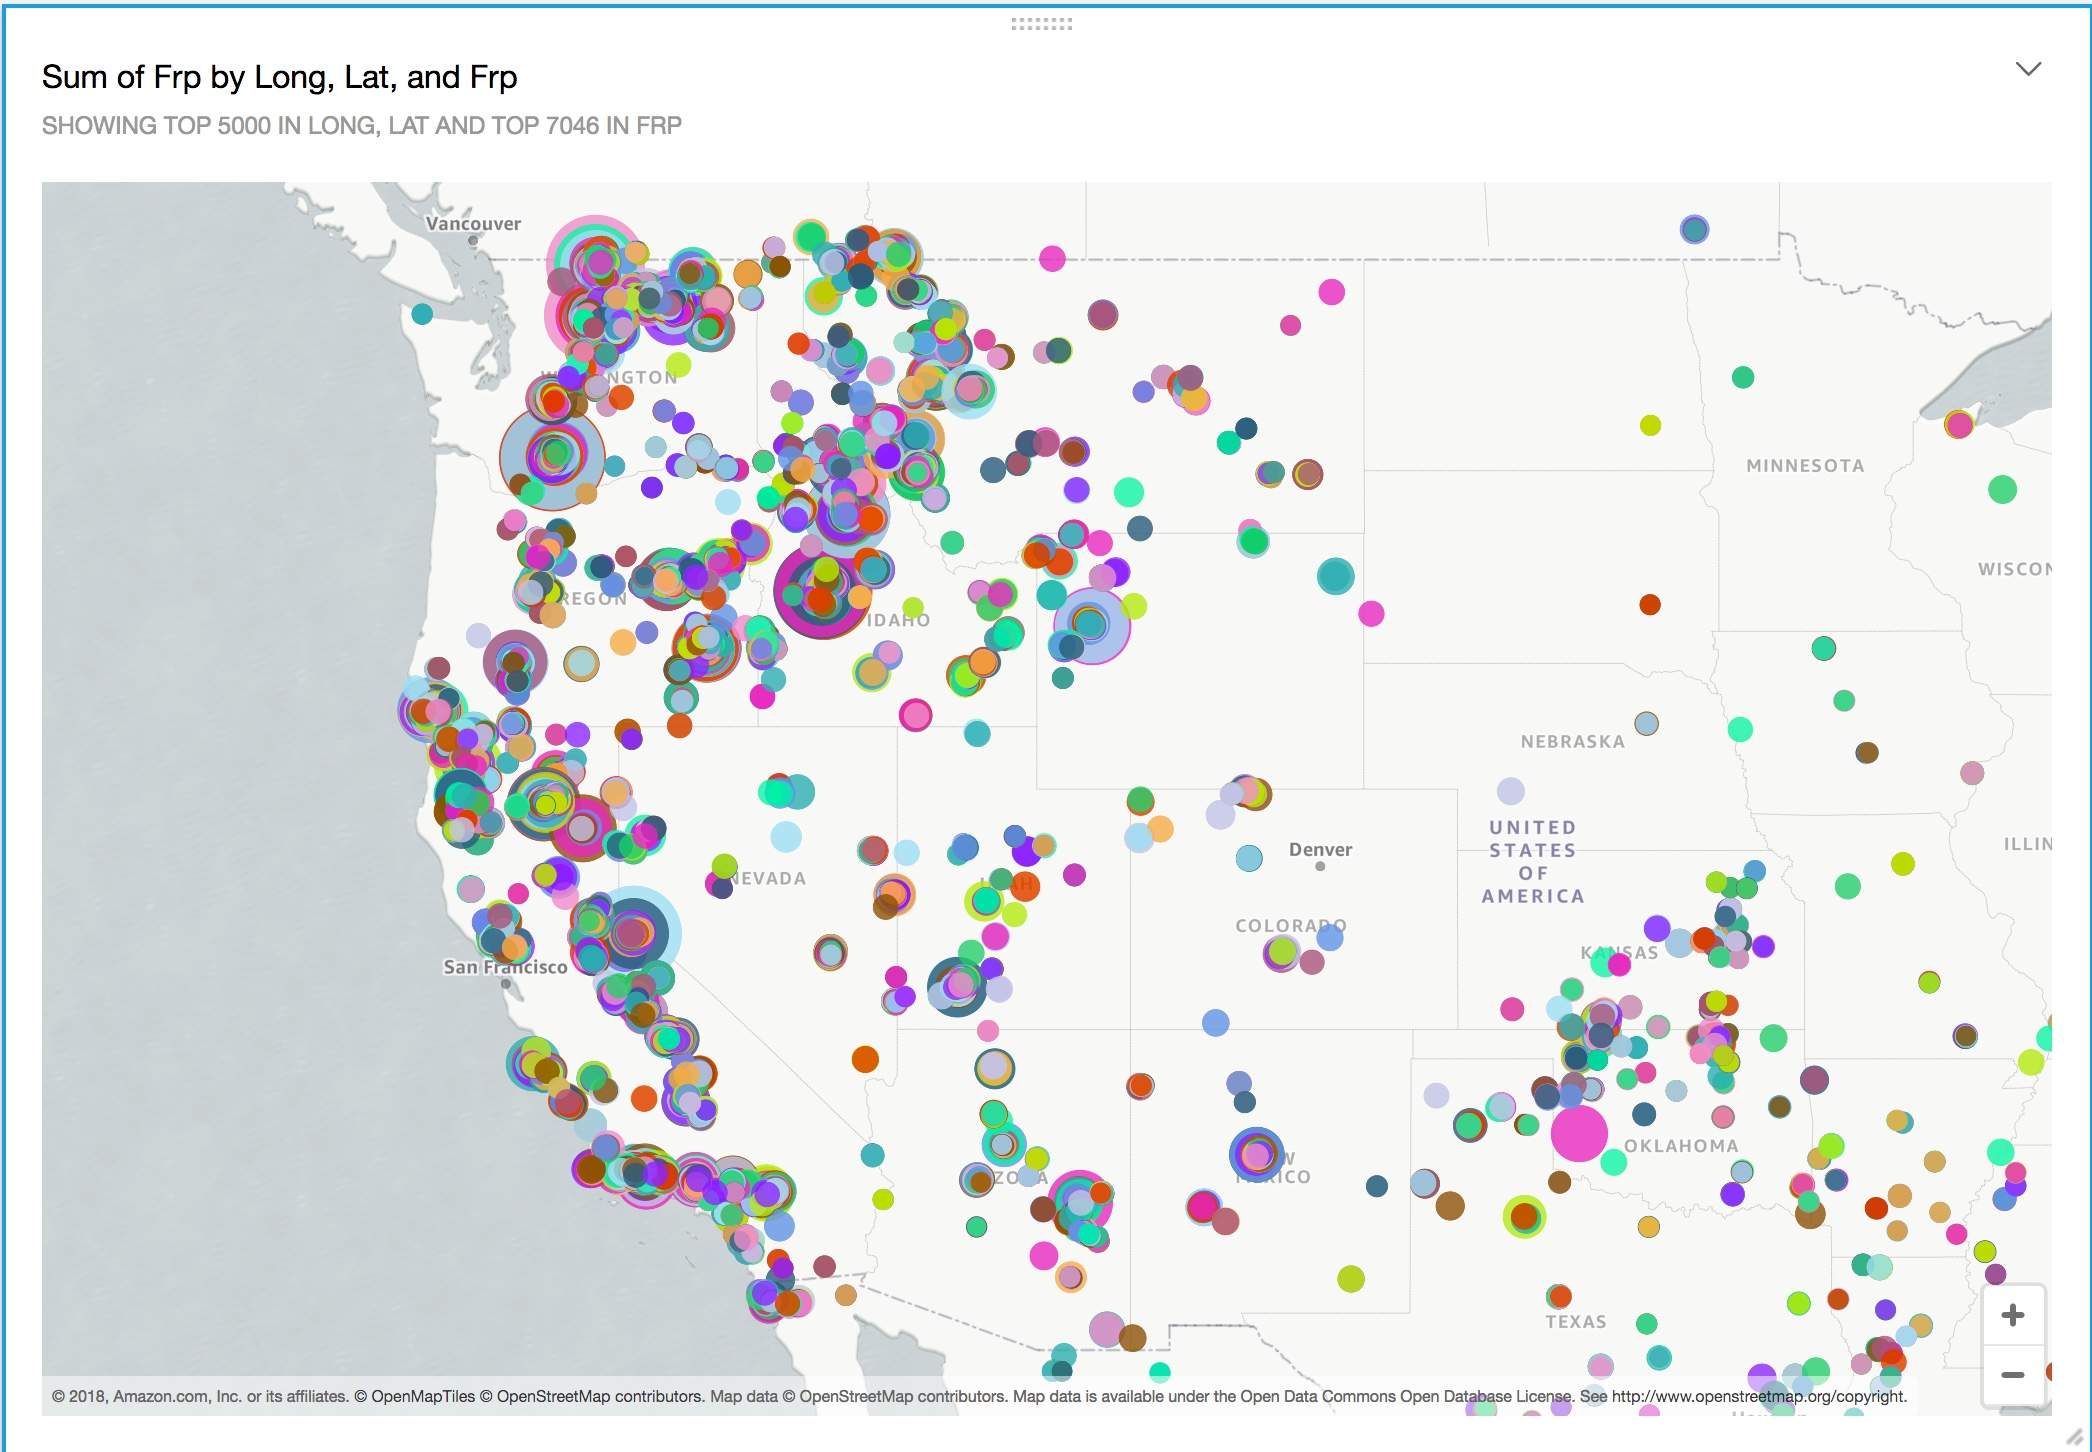

In [27]:
from IPython.display import Image
Image(filename='images/Forest Fire 2016 - 2017.jpeg') 

### Delete endpoints

In [ ]:
predictor.delete_endpoint()